# Data Reading

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

In [2]:
train_data = pd.read_csv("X_train.csv", index_col=[0])
test_data = pd.read_csv("X_test.csv", index_col=[0])
ytrain = pd.read_csv("y_train.csv", index_col=[0])
vehical_data = pd.read_csv("vehicle_registration_data_2018.csv", index_col=[0])

c:\users\divya\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


* data shapes

In [3]:
print(train_data.shape, test_data.shape, ytrain.shape, vehical_data.shape)

(2019036, 33) (456460, 33) (2019036, 2) (1865612, 19)


In [5]:
# mapping ytrain to pred in one dataframe
train_data['pred'] = ytrain['UNITS']

In [6]:
tdata = train_data.copy()
tedata = test_data.copy()

# Visualization of data

* Zipcode vs average tier demand

In [7]:
pred_by_zipcode = train_data.groupby(['DC_ZIPCODE'])['pred'].mean()
_ = plt.figure(figsize=(24,6))
plt.plot(range(len(pred_by_zipcode)), pred_by_zipcode.values)
plt.xticks(range(len(pred_by_zipcode)),pred_by_zipcode.keys(),rotation='vertical')
plt.show()

* Monthly_Top_1_Customer vs demand.

In [8]:
pred_by_top_1 = train_data.groupby(['Monthly_Top_1_Customer_Zip'])['pred'].mean()
_ = plt.figure(figsize=(24,6))
plt.plot(range(len(pred_by_top_1)), pred_by_top_1.values)
plt.show()

* freq distribution of dc_zipcode

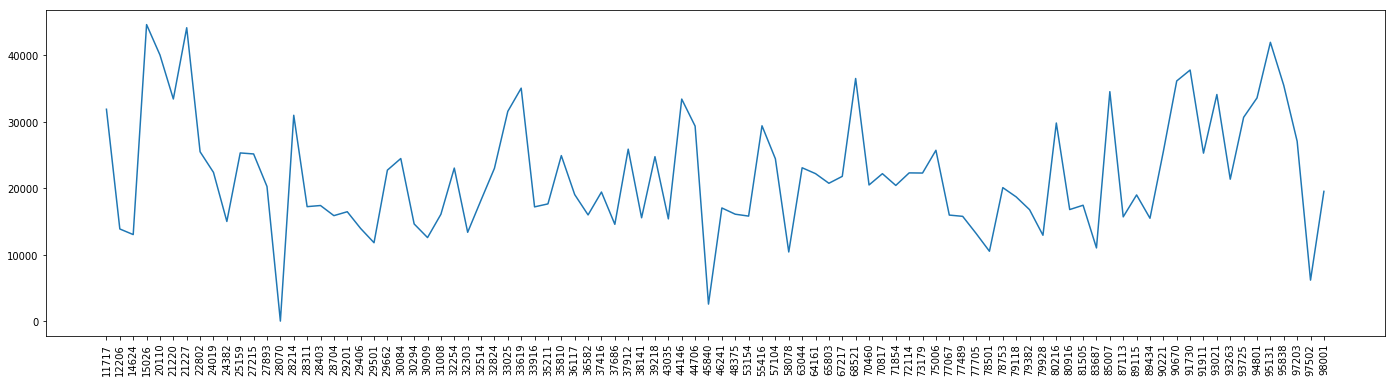

In [9]:
number_of_by_zipcode = train_data.groupby(['DC_ZIPCODE'])['idx'].count()
_ = plt.figure(figsize=(24,6))
plt.plot(range(len(number_of_by_zipcode)), number_of_by_zipcode.values)
plt.xticks(range(len(number_of_by_zipcode)),number_of_by_zipcode.keys(),rotation='vertical')
plt.show()

# Helper functions
* some function to help develope model and for data

In [10]:
def minmax(df1, cols):
    df = df1.copy()
    for c in cols:
        mn = df[c].min()
        mx = df[c].max()
        df[c] = df[c].apply(lambda x: (x-mn)/(mx-mn) )
    return df

def rmse(ypred, ytrue):
    assert len(ypred) == len(ytrue)
    return np.sqrt(np.sum((ypred-ytrue) ** 2)/len(ytrue))

# author : divya
def mapper(arr):
    for i in range(len(arr)): 
        if (int(arr[i])%2 == 0): 
            arr[i] = int(arr[i]) 
        else: 
            arr[i] = int(arr[i])+1 
    return arr

# Preprocessing and preparing of data

* Manual feature engineering which features to use

In [11]:
cat_cols = ['DC_ZIPCODE','Invoice_Week','CATEGORY','TIER','SPEED_RATING_CODE','RIM_DIAMETER_SIZE_CODE']
num_cols = ['WIDTH', 'HEIGHT','AVG_UNIT_WEIGHT','SELLING_PRICE', 'Monthly_Top_1_Customer_Total_Sales', 'Monthly_Top_2_Customer_Total_Sales', 'Monthly_Top_3_Customer_Total_Sales', 'Monthly_Top_4_Customer_Total_Sales', 'Monthly_Top_5_Customer_Total_Sales',]

In [12]:
tdata_v3 = train_data.copy()

In [14]:
tdata_v3 = tdata_v3[cat_cols + num_cols + ['pred']]

* dropping null values

In [15]:
tdata_v3 = tdata_v3.dropna()

* replacing all infinite values in 'SELLING_PRICE' feature with average 'SELLING_PRICE' aggregated based on TIER.

In [17]:
mean_sp_by_tier = tdata_v3[~tdata_v3['SELLING_PRICE'].isin([np.inf, -np.inf])].groupby(['TIER'])['SELLING_PRICE'].mean()

In [18]:
inf_idx = tdata_v3[tdata_v3['SELLING_PRICE'].isin([np.inf, -np.inf])].index
for i in inf_idx:
    tdata_v3.at[i,'SELLING_PRICE'] = mean_sp_by_tier[tdata_v3.loc[i,'TIER']]

* Map categorial features to numbers for lightbgm regression model.

In [20]:
maps = {}
testdata_v3 = test_data.copy()
testdata_v3 = test_data[cat_cols + num_cols]
for col_name in tdata_v3.columns:
    if(tdata_v3[col_name].dtype == 'object'):
        uq = tdata_v3[col_name].unique()
        d = {}
        for k,v in enumerate(uq):
            d[v] = k
        maps[col_name] = d
        print(maps[col_name])
        tdata_v3[col_name] = tdata_v3[col_name].apply( lambda x: maps[col_name][x])
        testdata_v3[col_name] = testdata_v3[col_name].apply( lambda x: maps[col_name][x])


{'Passenger Car / Mini-Van': 0, 'Performance Sport': 1, 'Winter': 2, 'Light Truck': 3, 'Luxury Touring': 4, 'AT Mud Utility': 5, 'SUV CUV': 6, 'HT SUV CUV': 7, 'Standard Passenger': 8, 'Performance Sport Car': 9}


c:\users\divya\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


{'Tier 3': 0, 'Tier 2': 1, 'Tier 1': 2, 'Tier 4': 3}
{'S': 0, 'H': 1, 'T': 2, 'M': 3, 'P': 4, 'R': 5, 'V': 6, 'Q': 7, 'W': 8, 'Z': 9, 'Y': 10, 'L': 11, '(Y)': 12, 'N': 13}


In [28]:
tdata_v3.shape,testdata_v3.shape

((2017298, 16), (456460, 15))

### splitting the data into train and validation set

In [30]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
xtr_v3, xte_v3, ytr_v3, yte_v3 = train_test_split(tdata_v3.loc[:,tdata_v3.columns!='pred'], tdata_v3['pred'], test_size=0.4, random_state=42)
train_lgb = lgb.Dataset(xtr_v3, ytr_v3 ,free_raw_data=False)
test_lgb = lgb.Dataset(xte_v3, yte_v3, free_raw_data=False)

# model training

* tuned parameters for boosting tree based model

In [32]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'l2_root'},
    'num_leaves': 70,
    'learning_rate': 0.06,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'verbose': 0,
    'num_trees': 750
}

* Training model with tuned parameters

In [33]:
mdl = lgb.train(params,
                train_lgb,
                valid_sets=test_lgb)

c:\users\divya\appdata\local\programs\python\python36\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 62.0682	valid_0's rmse: 7.87834	valid_0's l1: 5.0516
[2]	valid_0's l2: 61.3255	valid_0's rmse: 7.83106	valid_0's l1: 5.03684
[3]	valid_0's l2: 60.6592	valid_0's rmse: 7.7884	valid_0's l1: 5.02228
[4]	valid_0's l2: 60.0452	valid_0's rmse: 7.74889	valid_0's l1: 5.00783
[5]	valid_0's l2: 59.4723	valid_0's rmse: 7.71183	valid_0's l1: 4.99491
[6]	valid_0's l2: 58.9757	valid_0's rmse: 7.67956	valid_0's l1: 4.98348
[7]	valid_0's l2: 58.542	valid_0's rmse: 7.65128	valid_0's l1: 4.97314
[8]	valid_0's l2: 58.1544	valid_0's rmse: 7.6259	valid_0's l1: 4.96519
[9]	valid_0's l2: 57.7875	valid_0's rmse: 7.60181	valid_0's l1: 4.95601
[10]	valid_0's l2: 57.4666	valid_0's rmse: 7.58067	valid_0's l1: 4.94776
[11]	valid_0's l2: 57.1508	valid_0's rmse: 7.55981	valid_0's l1: 4.94016
[12]	valid_0's l2: 56.896	valid_0's rmse: 7.54294	valid_0's l1: 4.93426
[13]	valid_0's l2: 56.648	valid_0's rmse: 7.52649	valid_0's l1: 4.92698
[14]	valid_0's l2: 56.3988	valid_0's rmse: 7.50991	valid_0's l1: 4

[114]	valid_0's l2: 49.3426	valid_0's rmse: 7.02443	valid_0's l1: 4.69695
[115]	valid_0's l2: 49.3243	valid_0's rmse: 7.02313	valid_0's l1: 4.69648
[116]	valid_0's l2: 49.3091	valid_0's rmse: 7.02204	valid_0's l1: 4.6961
[117]	valid_0's l2: 49.2824	valid_0's rmse: 7.02015	valid_0's l1: 4.69537
[118]	valid_0's l2: 49.2441	valid_0's rmse: 7.01741	valid_0's l1: 4.69374
[119]	valid_0's l2: 49.2095	valid_0's rmse: 7.01495	valid_0's l1: 4.69248
[120]	valid_0's l2: 49.1873	valid_0's rmse: 7.01337	valid_0's l1: 4.69176
[121]	valid_0's l2: 49.1319	valid_0's rmse: 7.00941	valid_0's l1: 4.68952
[122]	valid_0's l2: 49.0927	valid_0's rmse: 7.00662	valid_0's l1: 4.68795
[123]	valid_0's l2: 49.0626	valid_0's rmse: 7.00447	valid_0's l1: 4.68704
[124]	valid_0's l2: 49.0401	valid_0's rmse: 7.00286	valid_0's l1: 4.68593
[125]	valid_0's l2: 49.0068	valid_0's rmse: 7.00048	valid_0's l1: 4.68472
[126]	valid_0's l2: 48.9689	valid_0's rmse: 6.99778	valid_0's l1: 4.68321
[127]	valid_0's l2: 48.9374	valid_0's r

[226]	valid_0's l2: 47.2199	valid_0's rmse: 6.87167	valid_0's l1: 4.61464
[227]	valid_0's l2: 47.214	valid_0's rmse: 6.87124	valid_0's l1: 4.61445
[228]	valid_0's l2: 47.1964	valid_0's rmse: 6.86996	valid_0's l1: 4.61384
[229]	valid_0's l2: 47.1819	valid_0's rmse: 6.86891	valid_0's l1: 4.61344
[230]	valid_0's l2: 47.1655	valid_0's rmse: 6.86772	valid_0's l1: 4.61262
[231]	valid_0's l2: 47.1493	valid_0's rmse: 6.86653	valid_0's l1: 4.61214
[232]	valid_0's l2: 47.138	valid_0's rmse: 6.86572	valid_0's l1: 4.61178
[233]	valid_0's l2: 47.1212	valid_0's rmse: 6.86449	valid_0's l1: 4.61132
[234]	valid_0's l2: 47.116	valid_0's rmse: 6.86411	valid_0's l1: 4.61118
[235]	valid_0's l2: 47.1031	valid_0's rmse: 6.86317	valid_0's l1: 4.61069
[236]	valid_0's l2: 47.0805	valid_0's rmse: 6.86153	valid_0's l1: 4.60901
[237]	valid_0's l2: 47.0673	valid_0's rmse: 6.86056	valid_0's l1: 4.60834
[238]	valid_0's l2: 47.0495	valid_0's rmse: 6.85926	valid_0's l1: 4.60759
[239]	valid_0's l2: 47.0391	valid_0's rms

[339]	valid_0's l2: 46.0127	valid_0's rmse: 6.78327	valid_0's l1: 4.56396
[340]	valid_0's l2: 46.0071	valid_0's rmse: 6.78285	valid_0's l1: 4.56374
[341]	valid_0's l2: 45.9939	valid_0's rmse: 6.78188	valid_0's l1: 4.56331
[342]	valid_0's l2: 45.9813	valid_0's rmse: 6.78095	valid_0's l1: 4.56287
[343]	valid_0's l2: 45.9698	valid_0's rmse: 6.78011	valid_0's l1: 4.56245
[344]	valid_0's l2: 45.9578	valid_0's rmse: 6.77922	valid_0's l1: 4.56201
[345]	valid_0's l2: 45.9547	valid_0's rmse: 6.77899	valid_0's l1: 4.56187
[346]	valid_0's l2: 45.9488	valid_0's rmse: 6.77856	valid_0's l1: 4.56167
[347]	valid_0's l2: 45.9356	valid_0's rmse: 6.77758	valid_0's l1: 4.56076
[348]	valid_0's l2: 45.9342	valid_0's rmse: 6.77748	valid_0's l1: 4.56068
[349]	valid_0's l2: 45.9294	valid_0's rmse: 6.77712	valid_0's l1: 4.56053
[350]	valid_0's l2: 45.9228	valid_0's rmse: 6.77663	valid_0's l1: 4.56031
[351]	valid_0's l2: 45.9147	valid_0's rmse: 6.77604	valid_0's l1: 4.55962
[352]	valid_0's l2: 45.9052	valid_0's 

[454]	valid_0's l2: 45.2134	valid_0's rmse: 6.72409	valid_0's l1: 4.52968
[455]	valid_0's l2: 45.2047	valid_0's rmse: 6.72345	valid_0's l1: 4.5293
[456]	valid_0's l2: 45.2023	valid_0's rmse: 6.72327	valid_0's l1: 4.52922
[457]	valid_0's l2: 45.1998	valid_0's rmse: 6.72308	valid_0's l1: 4.52913
[458]	valid_0's l2: 45.196	valid_0's rmse: 6.7228	valid_0's l1: 4.52895
[459]	valid_0's l2: 45.1907	valid_0's rmse: 6.7224	valid_0's l1: 4.52872
[460]	valid_0's l2: 45.18	valid_0's rmse: 6.72161	valid_0's l1: 4.52821
[461]	valid_0's l2: 45.1735	valid_0's rmse: 6.72113	valid_0's l1: 4.52792
[462]	valid_0's l2: 45.1664	valid_0's rmse: 6.7206	valid_0's l1: 4.52763
[463]	valid_0's l2: 45.1549	valid_0's rmse: 6.71974	valid_0's l1: 4.52707
[464]	valid_0's l2: 45.1438	valid_0's rmse: 6.71892	valid_0's l1: 4.52659
[465]	valid_0's l2: 45.1355	valid_0's rmse: 6.7183	valid_0's l1: 4.52632
[466]	valid_0's l2: 45.1269	valid_0's rmse: 6.71765	valid_0's l1: 4.52587
[467]	valid_0's l2: 45.1234	valid_0's rmse: 6.

[571]	valid_0's l2: 44.5754	valid_0's rmse: 6.67648	valid_0's l1: 4.49976
[572]	valid_0's l2: 44.5742	valid_0's rmse: 6.67639	valid_0's l1: 4.49975
[573]	valid_0's l2: 44.5719	valid_0's rmse: 6.67622	valid_0's l1: 4.49969
[574]	valid_0's l2: 44.5708	valid_0's rmse: 6.67614	valid_0's l1: 4.49964
[575]	valid_0's l2: 44.564	valid_0's rmse: 6.67563	valid_0's l1: 4.49918
[576]	valid_0's l2: 44.5599	valid_0's rmse: 6.67532	valid_0's l1: 4.49899
[577]	valid_0's l2: 44.5562	valid_0's rmse: 6.67504	valid_0's l1: 4.49886
[578]	valid_0's l2: 44.5528	valid_0's rmse: 6.67479	valid_0's l1: 4.49874
[579]	valid_0's l2: 44.5515	valid_0's rmse: 6.67469	valid_0's l1: 4.49874
[580]	valid_0's l2: 44.5442	valid_0's rmse: 6.67415	valid_0's l1: 4.49847
[581]	valid_0's l2: 44.537	valid_0's rmse: 6.6736	valid_0's l1: 4.49821
[582]	valid_0's l2: 44.529	valid_0's rmse: 6.673	valid_0's l1: 4.49798
[583]	valid_0's l2: 44.5245	valid_0's rmse: 6.67267	valid_0's l1: 4.49782
[584]	valid_0's l2: 44.5191	valid_0's rmse: 

[682]	valid_0's l2: 44.168	valid_0's rmse: 6.6459	valid_0's l1: 4.48082
[683]	valid_0's l2: 44.1614	valid_0's rmse: 6.6454	valid_0's l1: 4.48048
[684]	valid_0's l2: 44.1569	valid_0's rmse: 6.64506	valid_0's l1: 4.48031
[685]	valid_0's l2: 44.1535	valid_0's rmse: 6.64481	valid_0's l1: 4.48014
[686]	valid_0's l2: 44.1494	valid_0's rmse: 6.64451	valid_0's l1: 4.48
[687]	valid_0's l2: 44.1457	valid_0's rmse: 6.64422	valid_0's l1: 4.47988
[688]	valid_0's l2: 44.141	valid_0's rmse: 6.64387	valid_0's l1: 4.4797
[689]	valid_0's l2: 44.1368	valid_0's rmse: 6.64355	valid_0's l1: 4.47954
[690]	valid_0's l2: 44.1334	valid_0's rmse: 6.6433	valid_0's l1: 4.47939
[691]	valid_0's l2: 44.1288	valid_0's rmse: 6.64295	valid_0's l1: 4.47925
[692]	valid_0's l2: 44.126	valid_0's rmse: 6.64274	valid_0's l1: 4.4791
[693]	valid_0's l2: 44.1229	valid_0's rmse: 6.64251	valid_0's l1: 4.47894
[694]	valid_0's l2: 44.1204	valid_0's rmse: 6.64232	valid_0's l1: 4.47882
[695]	valid_0's l2: 44.1159	valid_0's rmse: 6.641

* writing result to res.csv file

In [35]:
pd.Series(mdl.predict(testdata_v3)).to_csv('res.csv', header=['predictions'],index_label='idx')